In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
import numpy as np
from matplotlib.lines import Line2D

In [128]:
key_dict = {'Undrer 1':'Lower1', 'Undrer 2':'Lower2', 'undrer 3': 'Lower3','Undrer 3': 'Lower3', '?vrer 1':'Upper1', '?vrer 2':'Upper2', '?vrer 3':'Upper3',
           'M?tare 1': 'Frost1', 'M?tare 2': 'Frost2', 'M?tare 3': 'Frost3', 'Snow 2': 'Snow2','snow 2':'Snow2','snow 3':'Snow3',  'Snow 3': 'Snow3',
           '?vre 1': 'Upper1', '?vre 2': 'Upper2', '?vre 3': 'Upper3', 'Extra 1': 'Extra1', 'Extra 2': 'Extra2','Extra 3': 'Extra3',
           'Temp_Min': 'Temp_Min', 'Temp_Max': 'Temp_Max', 'Precip': 'Precip','autumn precip': 'Precip', 'Precip ':'Precip',
           'frost 1': 'Frost1','Undre 3':'Lower1', 'Undre 1': 'Lower1', '?vre 1': 'Upper1', 'Undre 2': 'Lower2', '?vre 2':'Upper2', 'undre 3':'Lower3', '?vre 6': 'Upper3',
           'Grundvatten': 'Groundwater1', 'Grundvatten 2': 'Groundwater2', 'Undre 1': 'Lower1', 'Snow 2 extra': 'extra Snow2',
           'M?tare 2 extra': 'extra Frost2', 'M?tare 3 extra': 'extra Frost3', 'M?tare 1 extra': 'extra Frost1 ', 'Undre': 'Lower2', 'Temp': 'Temp_mean', '?vre': 'Upper2','Snow': 'Snow2', 'Snow extra': 'extra Snow2',
            'extra': 'extra Frost2', 'M?tare': 'Frost2', 'undre 2': 'Lower2', 'grundvatten': 'Groundwater', 'snow_3': 'Snow3', 'Precipitation': 'Precipitation',
           'undre 1': 'Lower1','m?tare 3': 'Frost3', 'snow extra 2':'extra Snow2', 'M?rtare 1': 'Frost1', 'm?tare 3': 'Frost3'}

In [172]:
# Functions for reading the csvs generated by Graph Grabber

def countrows(file):
    n=0
    slines = {}
    with open(file, 'r') as fp:
        for line in fp.read().splitlines():
            line = line.strip() 
            l = line.split(',')[0]
            try:
                float(l)
            except:
                if l != '':
                    slines[l]= n
            n+=1
    return slines

def skips(dictionary): # counts how much data should be read until the next series
    new= {}
    for key in dictionary:
        mini = float('-inf')
        for value in dictionary.values():
            if int(dictionary[key])- int(value) < 0 and  int(dictionary[key])-int(value) > mini:
                final_value = int(value)
                mini = int(dictionary[key]-value)
            new[key]= abs(mini)
    return(new)

def getdata(slines, file, year): # takes a file in splits it into series 
    df = {}
    n = 0
    for key in slines:
        header = slines[key] -n
        nrows = skips(slines)[key]-2
        key= key[10:]
        if ('Röbäcksdalen_61' or 'Röbäcksdalen_62') in file:
            #print(key + ' in RBD')
            R_dict= {'undra 1': 'Upper1','grundvatten': 'Groundwater', 'undra 2': 'Upper2','undrer 2': 'Upper2','M?rtare 1': 'Frost1','Extra 1': 'Extra1','Extra 2': 'Extra2', 'M?tare 1': 'Frost1', 'M?tare 3': 'Frost3', 'M?tare 2':'Frost2','Snow 2':'Snow2', 'Snow 3' :'Snow3','m?tare 3':'Frost3' ,'undrer 3': 'Upper3', 'frost 1': 'Lower1', 'frost 2': 'Lower2', 'frost 3': 'Lower3' }
            #print('in file '+ key)
            if key in R_dict:
                key = R_dict[key]
        elif key in key_dict:
            #print(key + ' in general dict')
            key= key_dict[key]   
        else : print('{} not in dict'.format(key))
        if nrows== float('inf'):
            df[key] = pd.read_csv(file, header = header, dtype = 'float', skip_blank_lines = True, names = ['Day', key], parse_dates = ['Day'], date_parser = lambda col: pd.to_datetime(col, origin = pd.Timestamp('19{}-10-11'.format(year-1)), unit = 'D'))
        else:
            try: 
                df[key]= pd.read_csv(file, header = header, dtype = 'float', skip_blank_lines = True,nrows = nrows, names = ['Day', key], parse_dates = ['Day'], date_parser = lambda col: pd.to_datetime(col, origin = pd.Timestamp('19{}-10-11'.format(year-1)), unit = 'D'))
            except: print('nrows = {}; header= {}; file= {}'.format(nrows, header, file))
        n+=1
        df[key]['DDay'] = df[key]['Day'].dt.round('D')
    return df

def read(name): # name is the name of the place with the year returns a seperate dataframe for each met, snow, frost grundvatten, etc....
    data = {}
    folder = "//storage.slu.se/Home$/anlr0006/Desktop/Frozen Soils/Historic Maps/Digitized/"  
    if os.path.isdir(folder+name+'/') is True:
        #print(name)
        folder = folder+name+'/'
    else: print(name + ' is not a folder')
    #names= ['met', 'frost', 'snow_ice' ]
    names= ['met', 'frost', 'snow_ice' ]
    year = int(name[-2:])
    for n in names:
        if os.path.isfile(folder+n+'.csv'):
            #print(n)
            file = folder+n+'.csv'
            slines = countrows(file)
            d= getdata(slines, file, year)
            data[n]= d
        else: print('{} does not have {}'.format(name, n))
        
    return data

In [174]:
# Functions for creating the modern figures

def color(label):
    if int(label[-1:]) == 1: 
        color = 'green'
    elif int(label[-1:]) == 2:
        color = 'purple'
    else: color = 'orange'
    return color
def dashed(label):
    if 'Upper' in label or 'Snow' in label:
        ls = 'dotted'
    else: ls = 'solid'
    return ls
def graph_met(ax, data, name):
    data = data['met']
    keys = data.keys()
    ax.set_title(name + ' Min and max air temperature')
    axP = ax.twinx()
    for key in keys:
        if key == 'Precip':
            df = data[key][['Precip', 'Day']].set_index('Day')
            df= df.drop_duplicates()
            df = df.resample('1D', ).max().fillna(value = 0)
            axP.bar(df.index, df['Precip'], color = 'navy', alpha = 0.5)
            axP.set_ylim(bottom = 0)
            axP.set_ylabel('Precipitation\n(mm\day)')
        elif 'Temp' in key:
            label = key
            if 'in' in key:
                color = 'c'
            elif 'ax' in key:
                color = 'lightcoral'
            else:
                color= 'lightcoral'
            ax.plot(data[key]['DDay'], data[key][key], label = label, color = color)
                
                
    ax.set_ylabel('Air Temperature\n(\u00b0C)')
    ax.legend()
def graph_frost(ax, data, name):
    data = data['frost']
    ax.set_title(name + ' freezing thawing rates')
    for key in data.keys():
        
        ax.plot(data[key]['DDay'], data[key][key], label = key, color = color(key), ls = dashed(key))
    ax.set_ylabel('Freezing/thawing rate\n(cm/day)')
    ax.set_xlim(ax.get_xlim())
    ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax= ax.get_xlim()[1], ls = 'dashed', color = 'k' , lw = 1)
    custom_lines = [Line2D([0], [0], color='grey', lw=2,),
                Line2D([0], [0], color='grey', lw=2, ls = 'dotted')]
    ax.legend(custom_lines, ['lower boundary', 'upper boundary'], ncol = 2)
def graph_ice(ax, data, name):
    custom_lines = [Line2D([0], [0], color='green', lw=2),
                Line2D([0], [0], color='purple', lw=2),
                Line2D([0], [0], color='orange', lw=2)]
    lines= ['snow removal', 'undisturbed 1', 'undisturbed 2']
    data = data['snow_ice']
    ax.set_title(name + ' frost and snow')
    gn = 'No'
    for key in data.keys():
        if 'water' in key:
            if name == 'Röbäcksdalen_61':
                ax.plot(data[key]['DDay'], -data[key][key], label = 'Goundwater', color = 'royalblue' )
            else:
                ax.plot(data[key]['DDay'], data[key][key], label = 'Goundwater', color = 'royalblue' )
            if gn == 'No':
                custom_lines.append( Line2D([0], [0], color='royalblue', lw=2))
                lines.append('groundwater')
                gn ='Yes'
        else:
            ax.plot(data[key]['DDay'], data[key][key], label = key, color = color(key), ls = dashed(key) )
    if ax.get_ylim()[0] < -190:
        ax.set_ylim((-190, ax.get_ylim()[1] + 5))
    else: ax.set_ylim((ax.get_ylim()[0]-5, ax.get_ylim()[1] + 5))
    ax.set_ylabel('Depth (cm)')
    ax.legend(custom_lines, lines)
    ax.set_xlim(ax.get_xlim())
    ax.hlines(y=0, xmin=ax.get_xlim()[0], xmax= ax.get_xlim()[1], ls = 'dashed', color = 'k' , lw = 1)

Malgomaj_62 does not have frost
Nytorp_62 does not have frost
Offer_58 does not have snow_ice
Röbäcksdalen_62 does not have frost
Uddeholm_62 does not have frost
Ås_62 does not have frost
Öjebyn_62 does not have frost


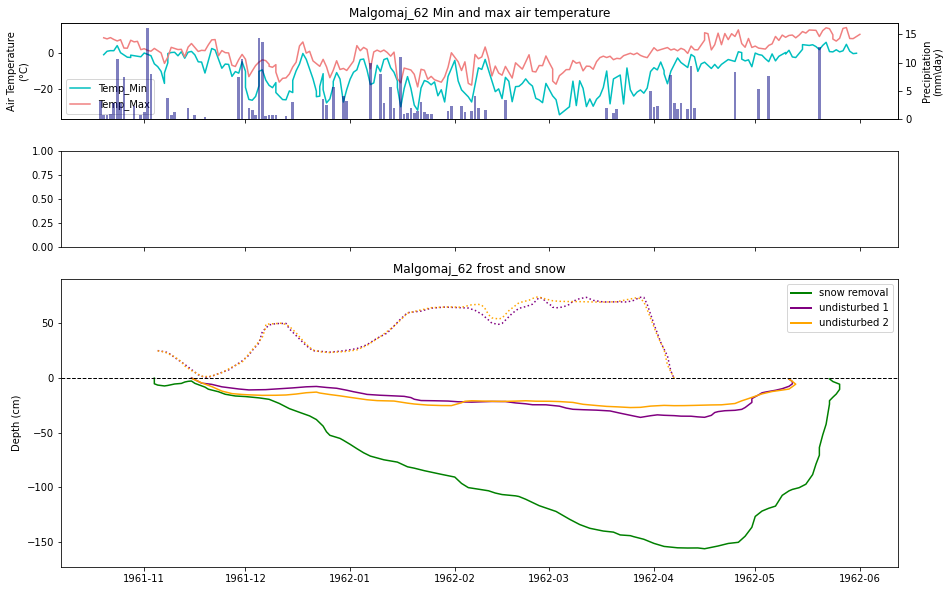

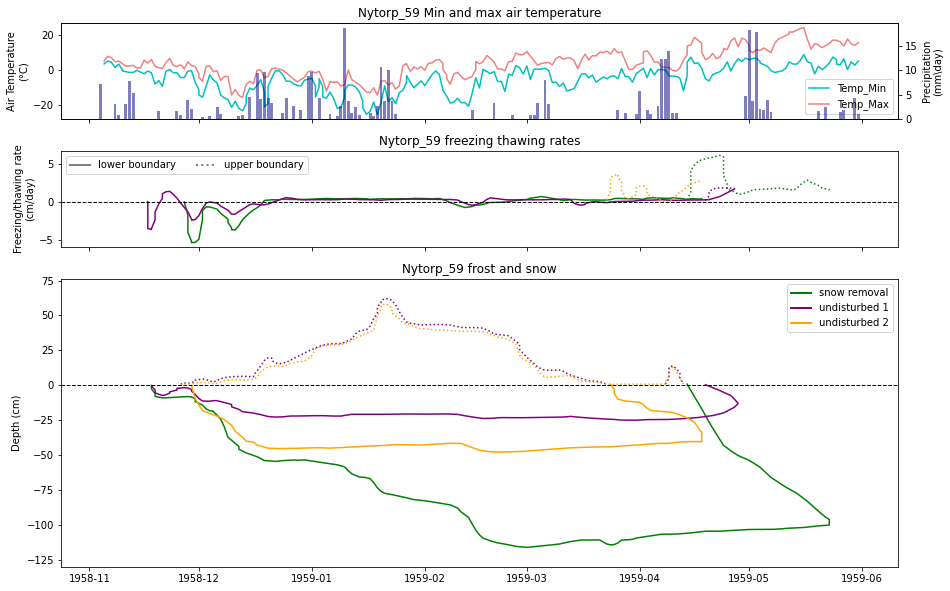

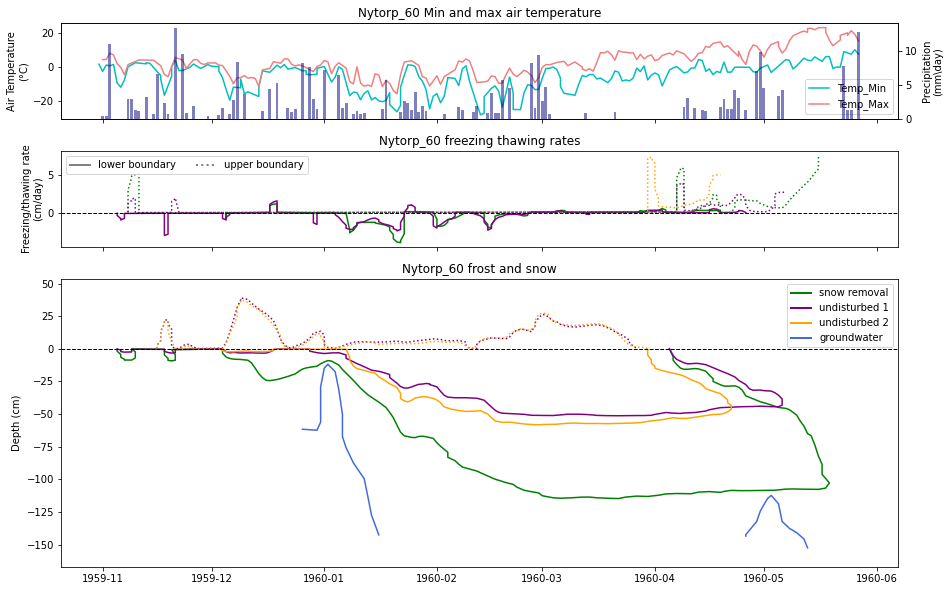

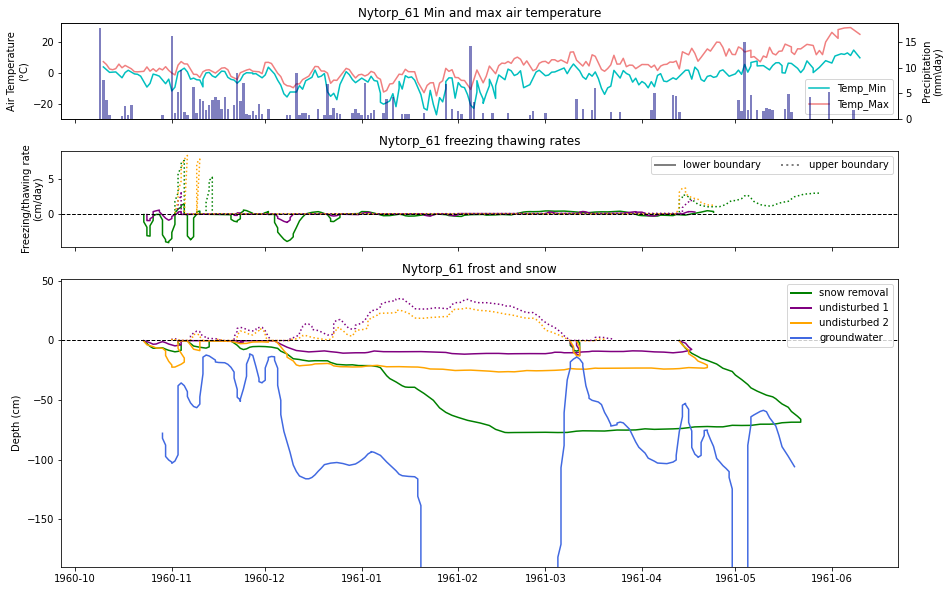

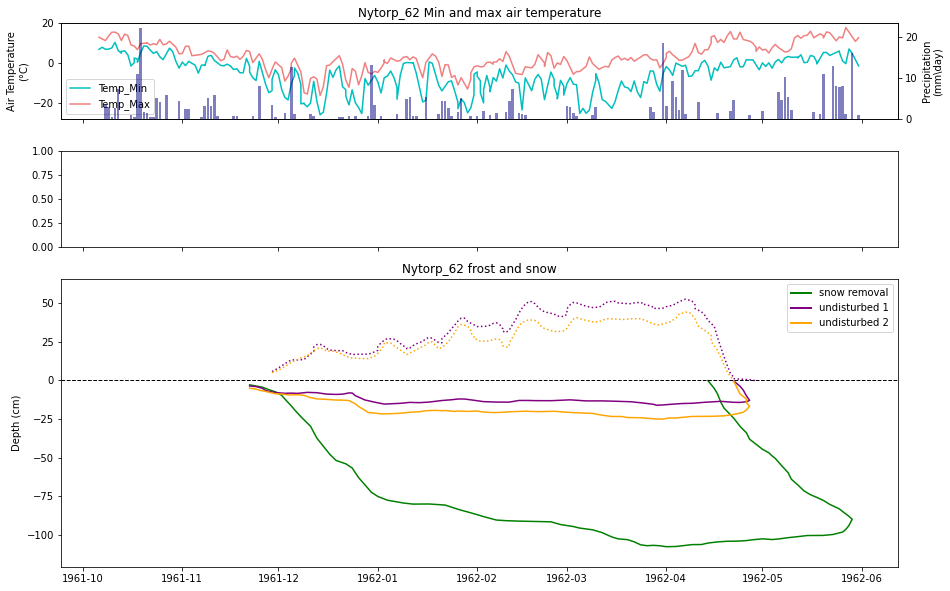

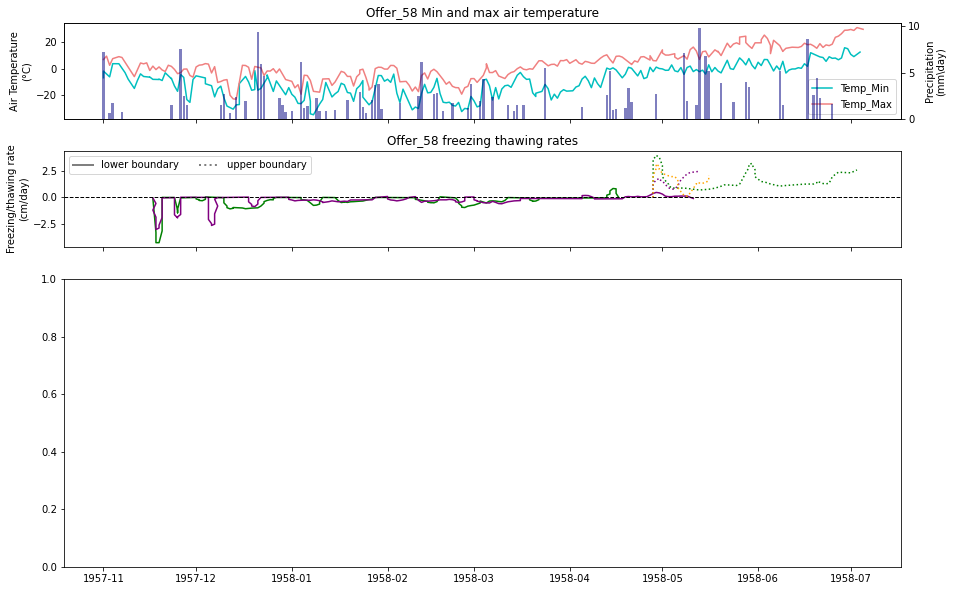

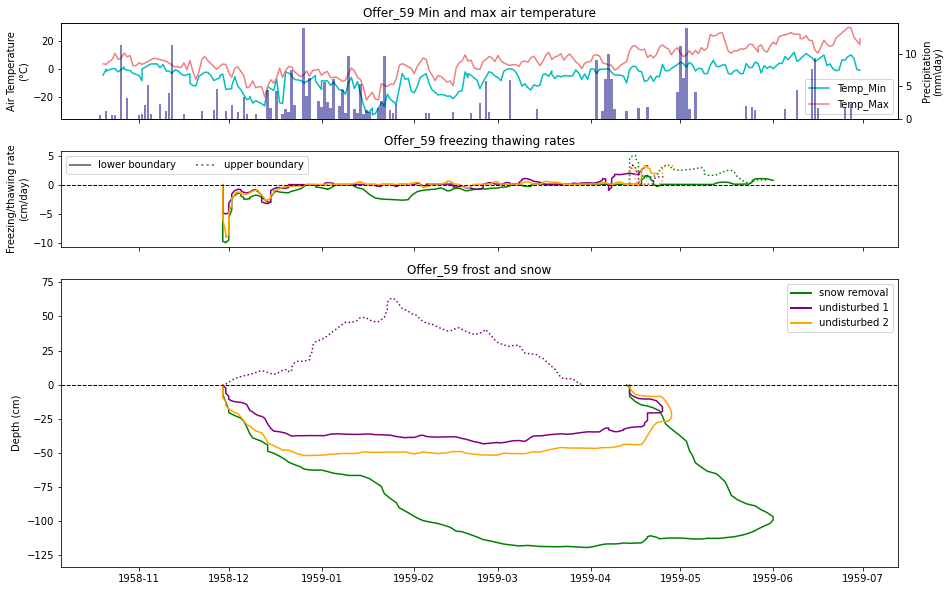

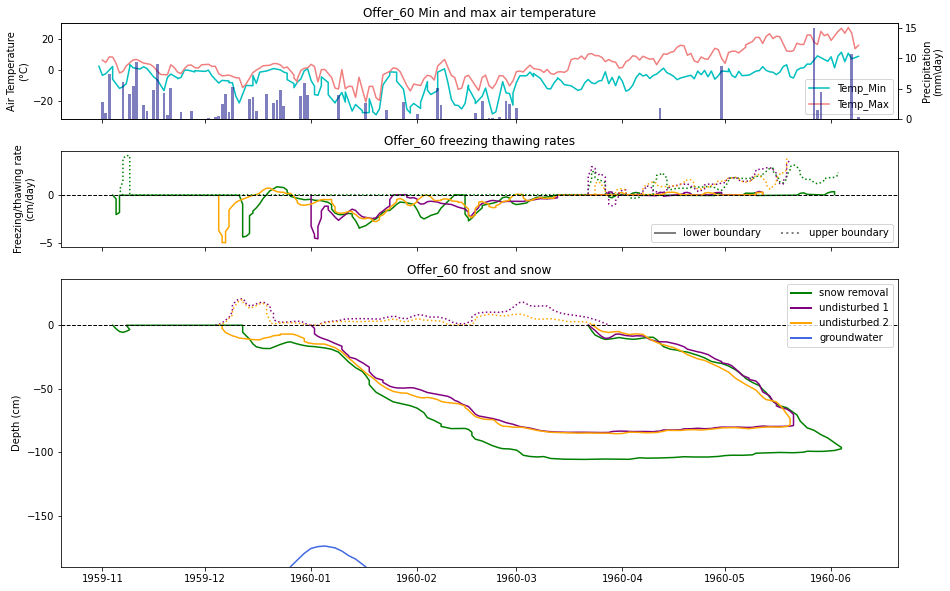

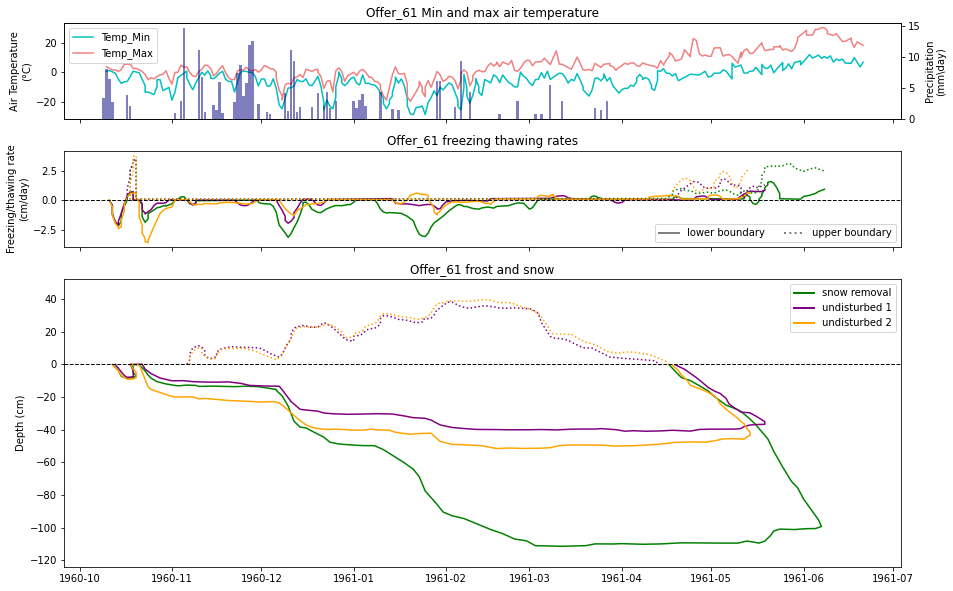

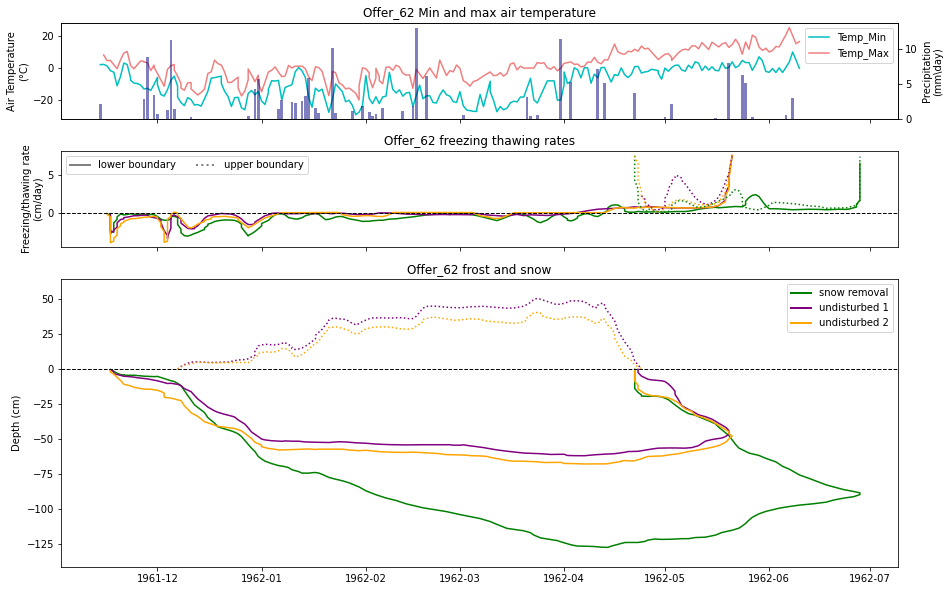

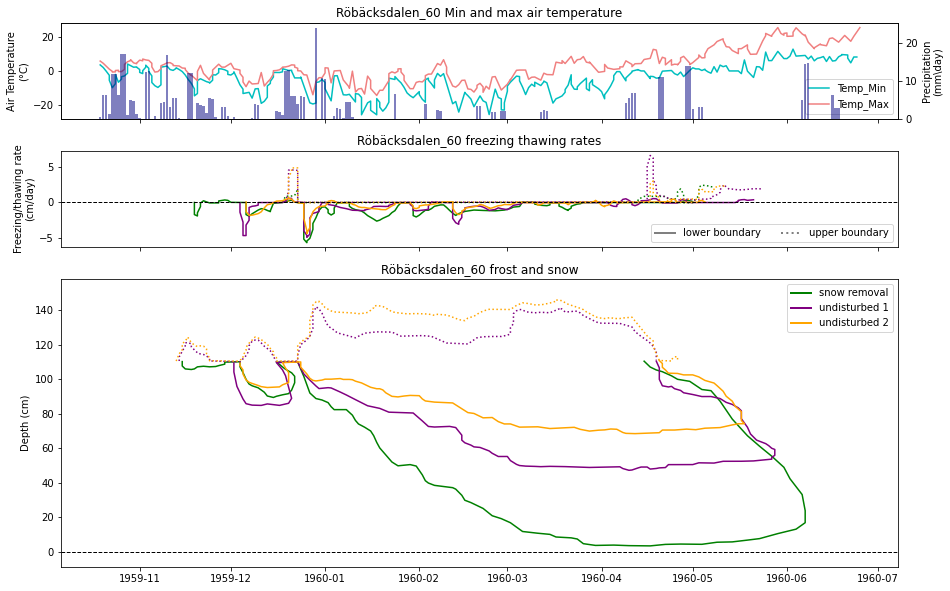

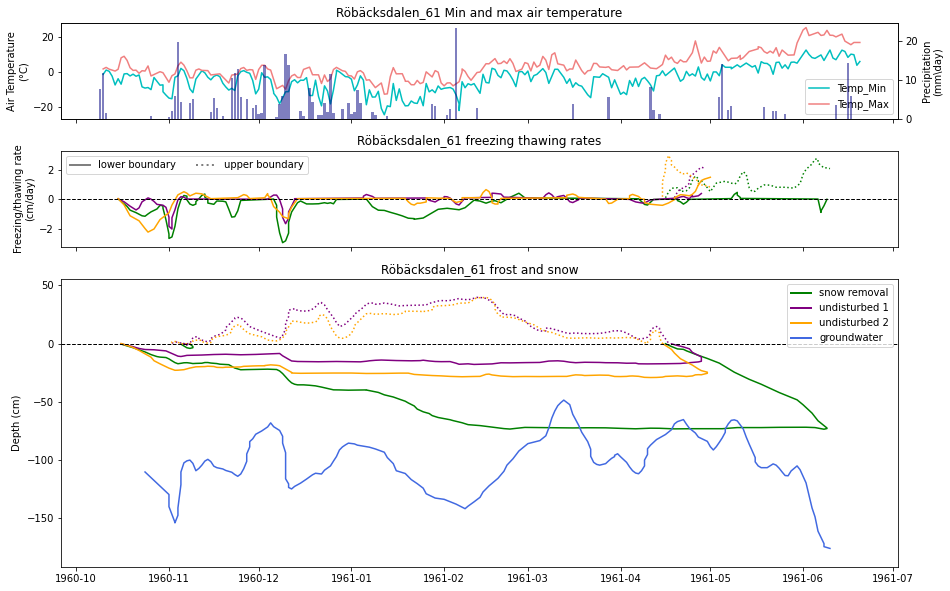

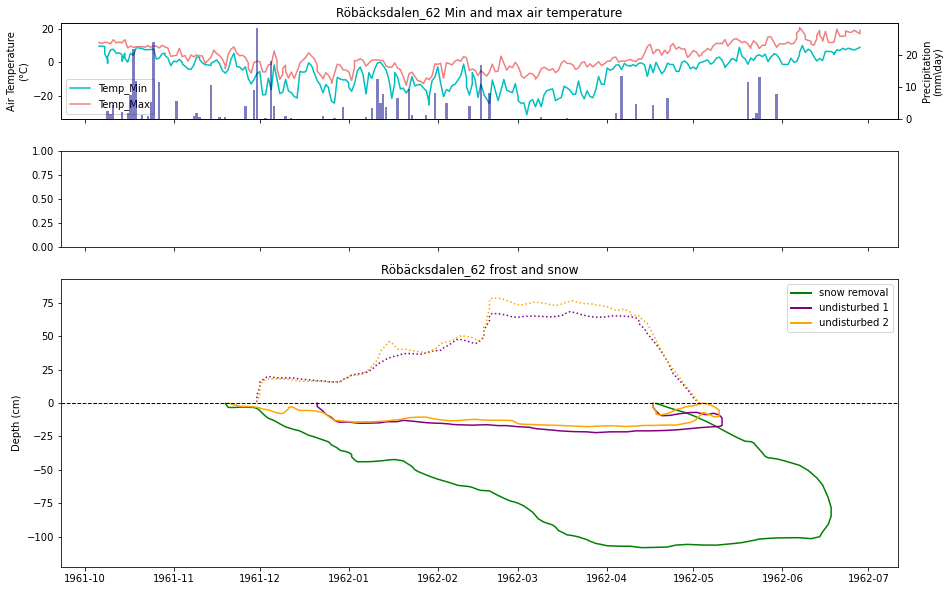

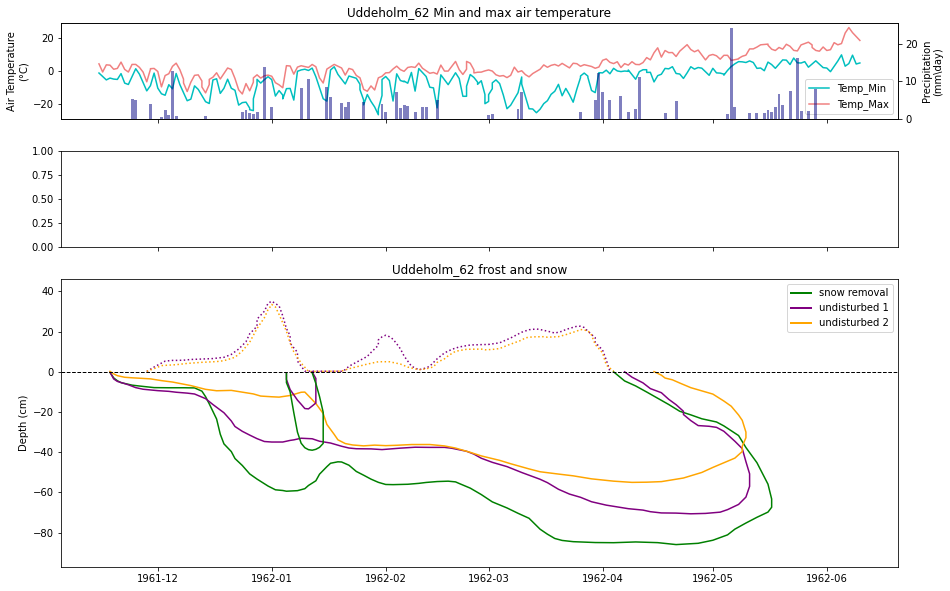

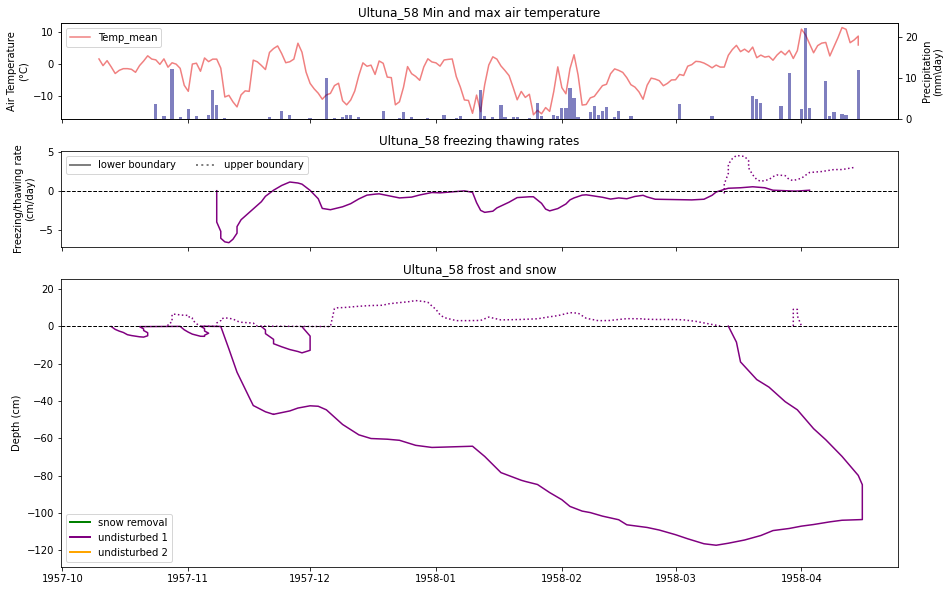

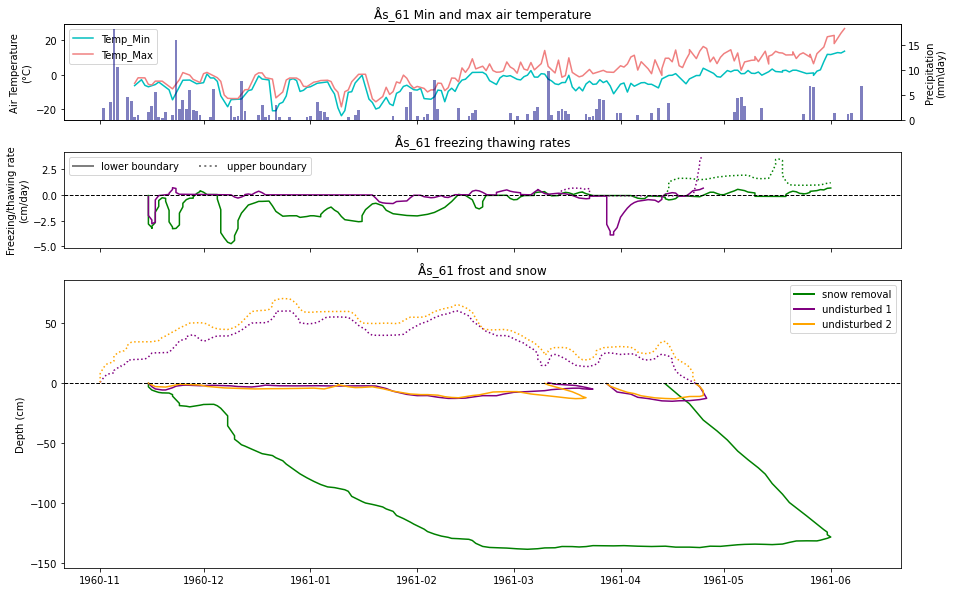

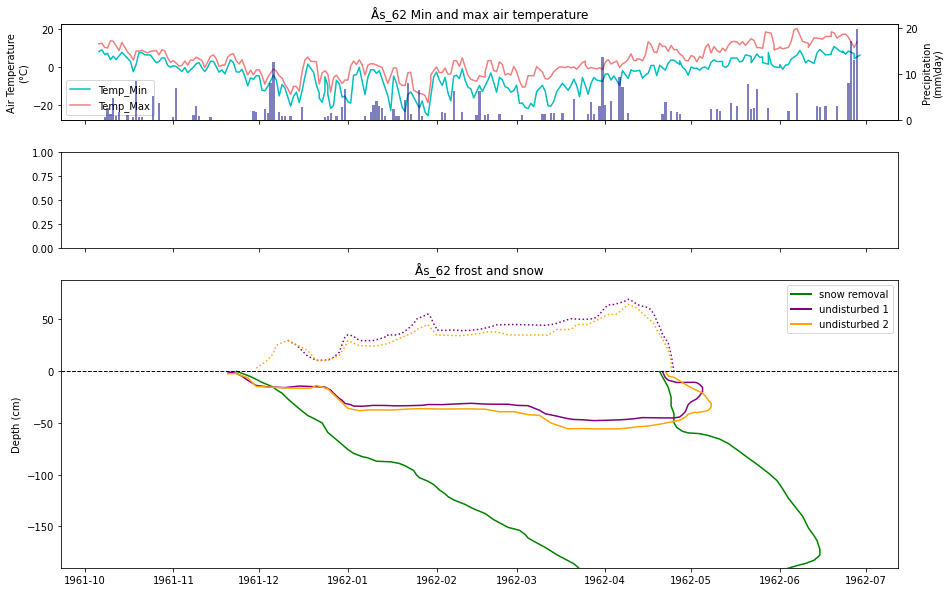

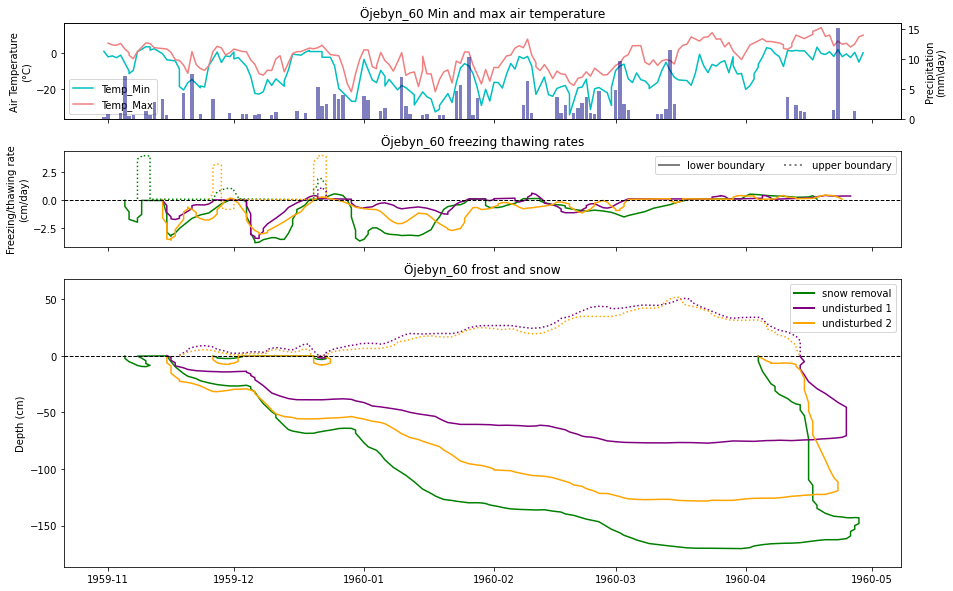

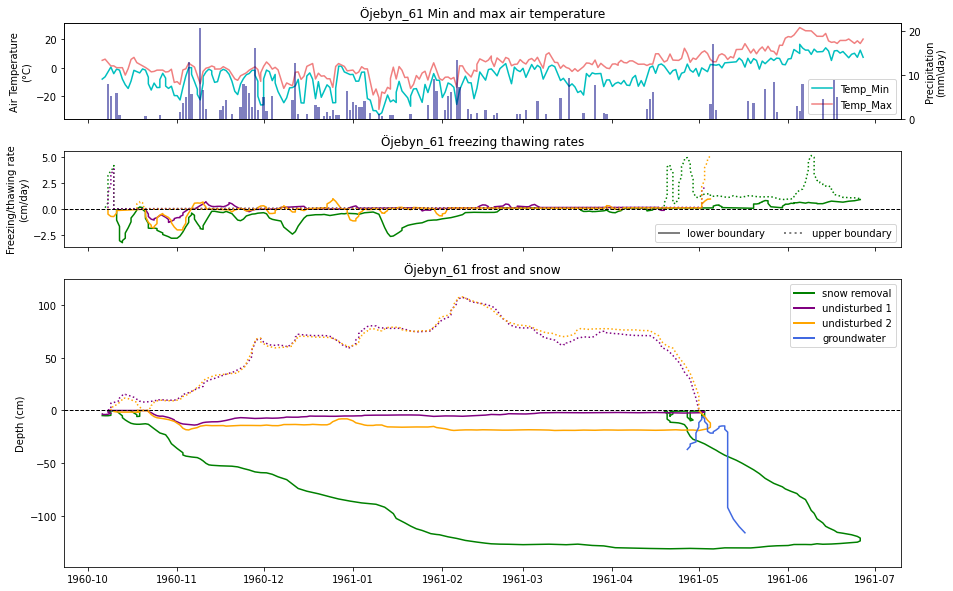

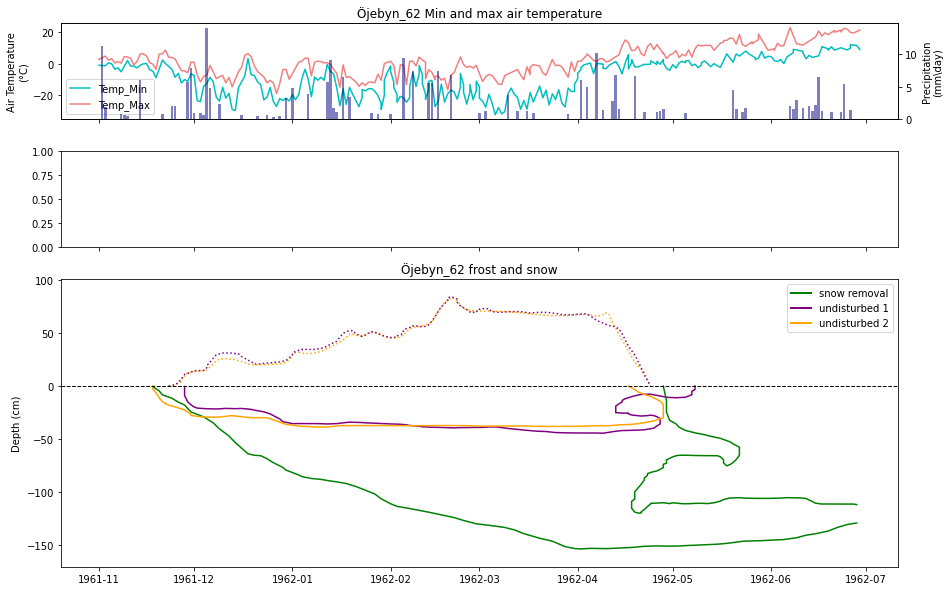

In [177]:
# creating and saving modern figures 

f = "\\\\storage.slu.se\\Home$\\anlr0006\\Desktop\\Frozen Soils\\Historic Maps\\Data\\"
directory = "\\\\storage.slu.se\\Home$\\anlr0006\\Desktop\\Frozen Soils\\Historic Maps\\Digitized\\"
names = [f.name for f in os.scandir(directory) if f.is_dir()]
for name in names:
    data= read(name)
    os.chdir(f)
    path = os.path.join(f, name)
    if os.path.exists(path):
        pass
    else: 
        os.mkdir(path)
    os.chdir(path)

    fig, ax = plt.subplots(3, figsize = (15,10), sharex = True, gridspec_kw={'height_ratios':[1,1,3]})
    graph_met(ax[0],data, name)
    try:
        graph_frost(ax[1], data, name)
    except:
        pass
    graph_ice(ax[2], data, name)
    # fig.savefig(name + '.png', dpi = 500)
    # fig.savefig(os.path.join("\\\\storage.slu.se\\Home$\\anlr0006\\Desktop\\Frozen Soils\\Historic Maps\\Data\\All\\", name + '.png'), dpi = 500)

In [203]:
# Saving csvs for each site, year and data category. DDay is the day while Day is the exact time of the point. 
for name in names:
    data= read(name)
    path = os.path.join(f, name)
    if os.path.exists(path):
        pass
    else: 
        os.mkdir(path)
    os.chdir(path)
    keys = {}
    for key in data.keys():
        keys[key] = data[key].keys()
        if key == 'met':
            d = data[key]['Precip'].set_index('Day')
            d= d.drop_duplicates()
            data[key]['Precip'] = d.resample('1D', ).max().fillna(value = 0)
        df = pd.concat([data[key][x] for x in data[key].keys()])
        df.to_csv(os.path.join(path, key+'.csv'), index = False)

Malgomaj_62 does not have frost
met
                            Day  Temp_Min                 DDay  Temp_Max  \
0 1961-10-19 16:19:05.469738080 -0.761887  1961-10-20 00:00:00       NaN   
1 1961-10-20 18:53:42.125710528  1.198614  1961-10-21 00:00:00       NaN   
2 1961-10-22 02:00:19.237236576  1.545377  1961-10-22 00:00:00       NaN   
3 1961-10-22 18:49:40.137615200  1.506571  1961-10-23 00:00:00       NaN   
4 1961-10-23 15:19:07.140926592  4.400581  1961-10-24 00:00:00       NaN   

   Precip  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
snow_ice
                            Day    Frost1       DDay  Frost2  Frost3  Snow2  \
0 1961-11-03 15:23:44.799158272 -0.197889 1961-11-04     NaN     NaN    NaN   
1 1961-11-04 00:06:45.906407872 -3.100264 1961-11-04     NaN     NaN    NaN   
2 1961-11-04 11:59:58.325384704 -5.343008 1961-11-04     NaN     NaN    NaN   
3 1961-11-04 19:55:26.604702528 -6.530343 1961-11-05     NaN     NaN    NaN   
4 1961-11-05 20:29:24.270587904

met
                            Day  Temp_Min                 DDay  Temp_Max  \
0 1958-10-19 12:02:00.669143232 -4.342933  1958-10-20 00:00:00       NaN   
1 1958-10-20 13:39:21.830020864 -0.155531  1958-10-21 00:00:00       NaN   
2 1958-10-21 08:58:24.931478208 -1.553288  1958-10-21 00:00:00       NaN   
3 1958-10-22 12:02:27.622390720  0.163158  1958-10-23 00:00:00       NaN   
4 1958-10-23 18:06:24.269918528  0.133763  1958-10-24 00:00:00       NaN   

   Precip  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
frost
                            Day    Lower1       DDay  Lower2  Lower3  Upper1  \
0 1958-11-28 12:34:16.147776384 -0.016896 1958-11-29     NaN     NaN     NaN   
1 1958-11-28 16:11:43.522084800 -0.627963 1958-11-29     NaN     NaN     NaN   
2 1958-11-28 22:24:49.107234624 -1.736442 1958-11-29     NaN     NaN     NaN   
3 1958-11-28 21:30:10.938114112 -3.030358 1958-11-29     NaN     NaN     NaN   
4 1958-11-28 21:38:40.295069056 -4.693853 1958-11-29     NaN 

met
                            Day  Temp_Min                 DDay  Temp_Max  \
0 1960-10-09 21:17:37.488930560 -1.218717  1960-10-10 00:00:00       NaN   
1 1960-10-10 21:45:41.436195776  1.260627  1960-10-11 00:00:00       NaN   
2 1960-10-11 22:59:38.006812928  0.561325  1960-10-12 00:00:00       NaN   
3 1960-10-12 23:27:41.954078080 -2.235884  1960-10-13 00:00:00       NaN   
4 1960-10-13 23:09:53.277991232 -7.258145  1960-10-14 00:00:00       NaN   

   Precip  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
frost
                            Day    Lower1       DDay  Upper1  Lower2  Upper2  \
0 1960-10-15 02:32:10.581267136  0.019930 1960-10-15     NaN     NaN     NaN   
1 1960-10-17 23:19:40.945646080 -0.491049 1960-10-18     NaN     NaN     NaN   
2 1960-10-19 05:53:41.766029184 -0.746452 1960-10-19     NaN     NaN     NaN   
3 1960-10-20 21:09:45.164529600 -0.917146 1960-10-21     NaN     NaN     NaN   
4 1960-10-22 15:59:34.955037952 -1.130372 1960-10-23     NaN 

met
                            Day  Temp_Min                 DDay  Temp_Max  \
0 1959-10-31 11:36:49.924073024  0.842156  1959-10-31 00:00:00       NaN   
1 1959-11-01 08:48:15.147230080 -2.182667  1959-11-01 00:00:00       NaN   
2 1959-11-02 11:11:39.595180544 -1.674717  1959-11-02 00:00:00       NaN   
3 1959-11-03 08:32:08.806142336 -2.635301  1959-11-03 00:00:00       NaN   
4 1959-11-04 10:59:22.937832576 -1.255783  1959-11-04 00:00:00       NaN   

   Precip  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN  
frost
                            Day    Lower1       DDay  Lower2  Lower3  Upper1  \
0 1959-11-04 22:45:15.912178816 -0.041287 1959-11-05     NaN     NaN     NaN   
1 1959-11-05 05:20:15.092218560 -0.595752 1959-11-05     NaN     NaN     NaN   
2 1959-11-05 12:56:43.808640448 -1.093340 1959-11-06     NaN     NaN     NaN   
3 1959-11-05 20:33:42.981140992 -1.491401 1959-11-06     NaN     NaN     NaN   
4 1959-11-06 06:13:45.577274176 -1.761489 1959-11-06     NaN 